In [2]:
%matplotlib inline

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("../input"))


['test.csv', 'train.csv', 'sample_submission.csv']


In [4]:
import mlxtend
import pandas_profiling

import seaborn as sns

from scipy import stats
from scipy.stats import norm, skew #for some statistics

import matplotlib.pyplot as plt


from tqdm import tqdm


In [5]:
%%time
train_df = pd.read_csv("../input/train.csv")


CPU times: user 11.9 s, sys: 685 ms, total: 12.6 s
Wall time: 12.6 s


In [6]:
train_df.shape

(4459, 4993)

In [7]:
TRAIN_SIZE = train_df.shape[0]

In [8]:
%%time
test_df = pd.read_csv("../input/test.csv", nrows=TRAIN_SIZE)
#test_df = pd.read_csv("../input/test.csv")


CPU times: user 14.2 s, sys: 320 ms, total: 14.5 s
Wall time: 14.5 s


# defining useful functions

In [9]:

%matplotlib inline

import os

import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm, skew #for some statistics

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import learning_curve

import mlxtend
from mlxtend.plotting import plot_learning_curves

import pandas_profiling





def checkNaValues(dataframe):
    """check nan values in dataframe"""
    
    print("\n# Is there any nan values?: ", dataframe.isna().all().all())
    
    print("## detail missing data ratio")
    #if dataframe.isna().all().all()
    dataframe_na = (dataframe.isna().sum()/len(dataframe))*100
    print(dataframe_na)
    dataframe_na = dataframe_na.drop(
        dataframe_na[dataframe_na == 0].index
    ).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio':dataframe_na})
    print(missing_data)
    
    
    """there is error. so not implemented yet
    # just plot the rate
    f, ax = plt.subplots(figsize=(15, 12))
    plt.xticks(rotation='90')
    sns.barplot(x=dataframe_na.index, y=dataframe_na.values)
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percent of missing values', fontsize=15)
    plt.title('Percent missing data by feature', fontsize=15)
    """

    
def checkObjTypeColumns(dataframe):
    """Check object dtype columns"""

    print("\n# object dtype columns")
    # object dtypeの列名からその列のデータのみを抽出
    df_object_type = dataframe[dataframe.select_dtypes(['object']).columns]
    #df_object_type = dataframe[[x for x in dataframe.columns if dataframe[x].dtypes == "object"]]
    print(df_object_type.head())
    #print(df_object_type.info()) # not useful info
    print(df_object_type.describe())

    
def checkValueCounts(dataframe):
    """check value counts of each features and find boolean feature or not."""

    print("# value_counts of each feature: ")
    for column in dataframe.columns:
        #print("## ", column, ": ")
        #print(dataframe[column].value_counts().head())
        value_counts = dataframe[column].value_counts().shape[0]
        if value_counts == 1:
            print(column, " -> single value. value count:  ", dataframe[column].value_counts().shape[0])            
        elif value_counts == 2:
            print(column, " -> maybe boolean. value count:  ", dataframe[column].value_counts().shape[0])
        else:
            print(column, " -> not boolean. value count:  ", dataframe[column].value_counts().shape[0])
            

def findSingleValueColmuns(dataframe):
    """check value counts of each features and find single value feature.
    Such column is no meaning to learn.
    """

    single_val_columns = []
    for column in dataframe.columns:
        value_counts = dataframe[column].value_counts().shape[0]
        if value_counts == 1:
            single_val_columns.append(column)
    return single_val_columns

            
def checkCorrelationOfFeatures(dataframe):
    """check correlation matix of each features"""

    # plot corr
    print("\n# correlation matrix")
    corrmat = dataframe.corr()
    plt.subplots(figsize=(12,9))
    sns.heatmap(corrmat, vmax=0.9, square=True)
    plt.show()
    print(corrmat)
    print()
    
    corr_values = corrmat.iloc[0]
    print("## highest correlation: ", corr_values.sort_values().head())
    print("## lowest correlation: ", corr_values.sort_values().tail())

    
def checkSkewness(dataframe):
    """check skewness of each features"""
    
    #numeric_feats = dataframe.dtypes[all_data.dtypes != "object"].index
    numeric_feats = dataframe.select_dtypes(exclude=['object'])
    #print(numeric_feats)
    # Check the skew of all numerical features
    skewed_feats = numeric_feats.apply(
        lambda x: skew(x.dropna())).sort_values(ascending=False)
    print("\n# Skew in numerical features: \n")
    skewness = pd.DataFrame({'Skew' :skewed_feats})
    print(skewness)
    
    return skewness
    
    
def checkAllDataInfo(dataframe):
    """print all dataframe info"""

    print(dataframe.head())
    print("\n# shape: ", dataframe.shape)
    print("\n# columns names: ", train_df.columns.values)
    
    print("\n# df.info(): ")
    print(dataframe.info())
    #print("\n# counts dtypes: \n", dataframe.dtypes.value_counts())# it is included in dataframe.info()

    print("\n# df.describe(): ")
    print(dataframe.describe())
    print()
    
    #print()
    #pandas_profiling.ProfileReport(dataframe)
    print()
    checkNaValues(dataframe)
    print()
    checkObjTypeColumns(dataframe)
    print()
    checkValueCounts(dataframe)
    print()
    #checkCorrelationOfFeatures(dataframe)
    
    print()
    checkSkewness(dataframe)
    
    
    
def my_plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        scoring="r2",
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt



def checkTargetInfo(dataframe, target_name="y"):
    """print target y value info"""
 
    # plot distribution
    sns.distplot(train_df[target_name], fit=norm)
    (mu, sigma) = norm.fit(train_df[target_name])
    print("mu, sigma:", mu, sigma)

    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')
    plt.ylabel('Frequency')
    plt.title('target value distribution')

    
    # plot skewness

    #print("skewness of y", skew(dataframe[target_name]))
    print("skewness of y", train_df[target_name].skew())
    fig = plt.figure()
    res = stats.probplot(train_df[target_name], plot=plt)
    plt.show()

    
    
def checkCorrelationOfSelectedFeatures(dataframe, columns):
    """check correlation matix of each features"""

    # plot corr
    print("\n# correlation matrix")
    corrmat = dataframe[columns].corr()
    plt.subplots(figsize=(12,9))
    sns.heatmap(corrmat, vmax=0.9, square=True, annot=True)
    plt.show()
    print(corrmat)
    

    
def splitToIdTargetFeatures(dataframe, id_name, target_name):
    """split train df to data, id and taret dataframes
    """
    id_df = dataframe[id_name]
    target_df = dataframe[target_name]
    features_df = dataframe.drop([id_name, target_name], axis=1)
    
    return id_df, target_df, features_df




# EDA

## general info

## checking in details

## checkTargetInfo

### apply logarithm transformation to tareget

/home/yuki/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


14.490239292748585 1.7507504829494496


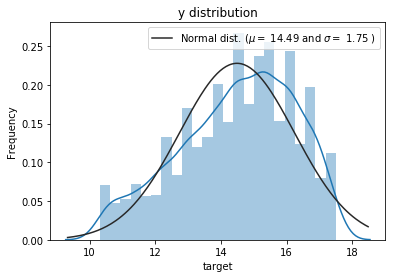

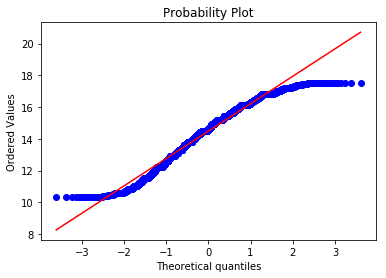

In [10]:
# apply logarithm transformation

train_df["target"] = np.log1p(train_df["target"])
sns.distplot(train_df["target"], fit=norm)

(mu, sigma) = norm.fit(train_df["target"])
print(mu, sigma)

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('y distribution')

fig = plt.figure()
res = stats.probplot(train_df["target"], plot=plt)
plt.show()


## pairplot

- not good idea to make function
- better to use pairplot() directly. more useful.

## pandas_profiling

----

# feature eng

## add some features before drop some columns


### add sum of zeros feature

In [11]:
def add_SumZeros(train, test):
    flist = [x for x in train.columns if not x in ['ID','target']]
    train.insert(1, 'SumZeros', (train[flist] == 0).astype(int).sum(axis=1))
    test.insert(1, 'SumZeros', (test[flist] == 0).astype(int).sum(axis=1))
    return train, test


In [12]:
%%time
train_df, test_df = add_SumZeros(train_df, test_df)


CPU times: user 3.34 s, sys: 1.08 s, total: 4.42 s
Wall time: 3.06 s


In [13]:
train_df.SumZeros.head()

0    4889
1    4924
2    4973
3    4969
4    4965
Name: SumZeros, dtype: int64

In [14]:
test_df.SumZeros.head()

0    4913
1    4979
2    4892
3    4871
4    4983
Name: SumZeros, dtype: int64

### add sum of values

In [15]:
def add_SumValues(train, test):
    flist = [x for x in train.columns if not x in ['ID','target']]
    
    train.insert(1, 'SumValues', (train[flist] != 0).astype(int).sum(axis=1))
    test.insert(1, 'SumValues', (test[flist] != 0).astype(int).sum(axis=1))

    return train, test

In [16]:
%%time
train_df, test_df = add_SumValues(train_df, test_df)


CPU times: user 3.8 s, sys: 1.35 s, total: 5.15 s
Wall time: 3.6 s


In [17]:
train_df.SumValues.head()

0    103
1     68
2     19
3     23
4     27
Name: SumValues, dtype: int64

In [18]:
test_df.SumValues.head()

0     79
1     13
2    100
3    121
4      9
Name: SumValues, dtype: int64

## add other Aggregates

In [19]:
other_agg_list = ['Mean', 'Median', 'Mode', 'Max', 'Var', 'Std']

def add_OtherAgg(train, test):
    flist = [x for x in train.columns if not x in ['ID','target','SumZeros','SumValues']]
    train['Mean']   = train[flist].mean(axis=1)
    train['Median'] = train[flist].median(axis=1)
    train['Mode']   = train[flist].mode(axis=1)
    train['Max']    = train[flist].max(axis=1)
    train['Var']    = train[flist].var(axis=1)
    train['Std']    = train[flist].std(axis=1)

    test['Mean']   = test[flist].mean(axis=1)
    test['Median'] = test[flist].median(axis=1)
    test['Mode']   = test[flist].mode(axis=1)
    test['Max']    = test[flist].max(axis=1)
    test['Var']    = test[flist].var(axis=1)
    test['Std']    = test[flist].std(axis=1)

    return train, test

In [20]:
%%time
train_df, test_df = add_OtherAgg(train_df, test_df)


CPU times: user 45.9 s, sys: 6.54 s, total: 52.4 s
Wall time: 44.9 s


In [21]:
train_df[other_agg_list].head()

,Mean,Median,Mode,Max,Var,Std
0,144413.611164,0.0,0.0,40000000.0,3.031989e+12,1.741261e+06
1,106585.186672,0.0,0.0,50000000.0,2.338739e+12,1.529294e+06
2,15267.481467,0.0,0.0,12000000.0,1.098310e+11,3.314076e+05
3,6690.175648,0.0,0.0,6000000.0,3.020618e+10,1.737993e+05
4,35803.245843,0.0,0.0,37662000.0,7.195723e+11,8.482761e+05


In [22]:
test_df[other_agg_list].head()

,Mean,Median,Mode,Max,Var,Std
0,442863.226849,0.0,0.0,9.605043e+08,2.064611e+14,1.436875e+07
1,18463.769828,0.0,0.0,3.176478e+07,3.714398e+11,6.094586e+05
2,117647.532959,0.0,0.0,8.000000e+07,3.293080e+12,1.814684e+06
3,354811.979455,0.0,0.0,1.000000e+08,9.775059e+12,3.126509e+06
4,26661.551225,0.0,0.0,1.077087e+08,2.354338e+12,1.534385e+06


In [23]:
added_cols_pls_target = ["target", 'SumZeros', 'SumValues']+other_agg_list
train_df[added_cols_pls_target].head()

,target,SumZeros,SumValues,Mean,Median,Mode,Max,Var,Std
0,17.453097,4889,103,144413.611164,0.0,0.0,40000000.0,3.031989e+12,1.741261e+06
1,13.304687,4924,68,106585.186672,0.0,0.0,50000000.0,2.338739e+12,1.529294e+06
2,16.118096,4973,19,15267.481467,0.0,0.0,12000000.0,1.098310e+11,3.314076e+05
3,14.508658,4969,23,6690.175648,0.0,0.0,6000000.0,3.020618e+10,1.737993e+05
4,16.482739,4965,27,35803.245843,0.0,0.0,37662000.0,7.195723e+11,8.482761e+05


In [24]:
corr = train_df[added_cols_pls_target].corr()
corr

,target,SumZeros,SumValues,Mean,Median,Mode,Max,Var,Std
target,1.000000,0.050515,-0.050515,0.206092,NaN,NaN,0.034356,-0.013170,0.137552
SumZeros,0.050515,1.000000,-1.000000,-0.659386,NaN,NaN,-0.173976,-0.119944,-0.389526
SumValues,-0.050515,-1.000000,1.000000,0.659386,NaN,NaN,0.173976,0.119944,0.389526
Mean,0.206092,-0.659386,0.659386,1.000000,NaN,NaN,0.326719,0.274386,0.691474
Median,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mode,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Max,0.034356,-0.173976,0.173976,0.326719,NaN,NaN,1.000000,0.947440,0.891486
Var,-0.013170,-0.119944,0.119944,0.274386,NaN,NaN,0.947440,1.000000,0.814261
Std,0.137552,-0.389526,0.389526,0.691474,NaN,NaN,0.891486,0.814261,1.000000


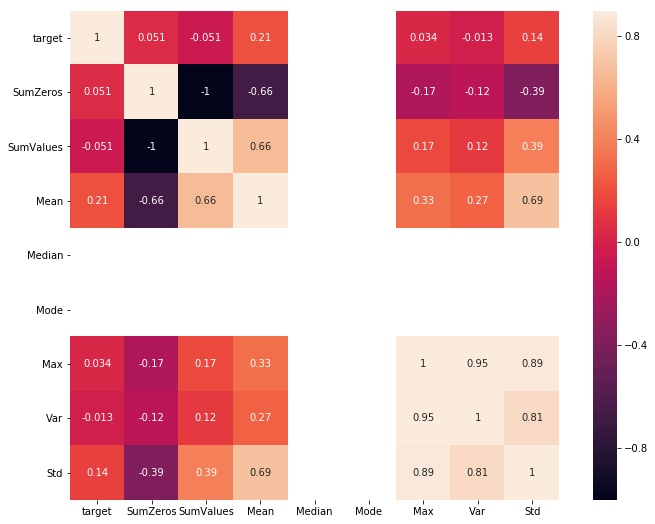

In [25]:
plt.subplots(figsize=(12,9))
sns.heatmap(corr, vmax=0.9, square=True, annot=True)
plt.show()

## remove single value column

In [26]:
single_val_columns = findSingleValueColmuns(train_df)

In [27]:
print("drop single value columns, ", len(single_val_columns), "columns were dropped")

drop single value columns,  258 columns were dropped


In [28]:
print("train_df.shape, test_df.shape")
print(train_df.shape, test_df.shape)

train_df.drop(single_val_columns, axis=1, inplace=True)
test_df.drop(single_val_columns, axis=1, inplace=True)

print(train_df.shape, test_df.shape)

train_df.shape, test_df.shape
(4459, 5001) (4459, 5000)
(4459, 4743) (4459, 4742)


## remove dupulicate column

remove if train_df data is same even if test_df data is not same.
because if train_df data is same, it cannot learn the differece.

comment out to reduce time

In [29]:
colsToRemove =  ['d60ddde1b', 'acc5b709d', 'f333a5f60', 'f8d75792f', '912836770', 'f333a5f60']
colsScaned =  ['d60ddde1b', 'acc5b709d', 'f333a5f60', 'f8d75792f', '912836770']
dupList =  {'34ceb0081': ['d60ddde1b'], '8d57e2749': ['acc5b709d', 'f333a5f60'], '168b3e5bc': ['f8d75792f'], 'a765da8bc': ['912836770']}

In [30]:
print("train_df.shape, test_df.shape")
print(train_df.shape, test_df.shape)

train_df.drop(colsToRemove, axis=1, inplace=True)
test_df.drop(colsToRemove, axis=1, inplace=True)

print(train_df.shape, test_df.shape)

train_df.shape, test_df.shape
(4459, 4743) (4459, 4742)
(4459, 4738) (4459, 4737)


## check Correlation and reduce high corr features

- if a feature have only one value, correlation become NAN.
- so better to check correlation after dropped one value features

## combine train/test to all_data

In [31]:
ntrain = train_df.shape[0]
all_data = pd.concat((train_df, test_df)).reset_index(drop=True)

all_id, all_target, all_data = splitToIdTargetFeatures(all_data, id_name="ID", target_name="target")


/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [32]:
all_data.head()

,001476ffa,0019109c4,0022de2b3,0024cd760,002d634dc,00302fe51,003da5628,006e72749,007d71f12,007ee91d1,...,ffa45bf70,ffa6b80e2,ffa903344,ffb34b926,ffca57b7b,ffcec956f,ffd2f9409,ffd50f0bf,ffdc4bcf8,ffec49dae
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
all_id.head()

0    000d6aaf2
1    000fbd867
2    0027d6b71
3    0028cbf45
4    002a68644
Name: ID, dtype: object

In [34]:
all_target.head()

0    17.453097
1    13.304687
2    16.118096
3    14.508658
4    16.482739
Name: target, dtype: float64

## skew feature

In [35]:
skewness = checkSkewness(all_data)
skewness.head(5)


# Skew in numerical features: 

                Skew
9685f5e16  94.347123
28690ae0d  94.248748
07cb6041d  94.182417
625525b5d  94.177077
ede70bfea  94.154209
df6a71cc7  94.141417
2b85882ad  94.140350
52588de80  94.097587
2b72620ae  94.077240
9fa984817  94.055658
5878b703c  94.020534
3d23e8abd  93.963359
3be4dad48  93.915185
3e0e55648  93.827672
73db5b43b  93.458314
ff7b471cd  93.288417
99258443a  93.232439
985f4005a  93.036880
26b423c42  92.967400
4ceef6dbd  92.791311
d9ce16f1c  92.778162
4877151a3  92.724249
cfa552462  92.570156
84067cfe0  92.343155
ef139d7ac  92.262692
969d32625  92.230946
180f8ed6e  92.225236
2127bb611  92.195580
578a07608  92.053592
950b9cf2d  92.008863
...              ...
68a945b18   8.459370
77deffdf0   8.451565
4bcf15776   8.406754
166008929   8.379911
9de83dc23   8.354975
cbb673163   8.348954
935ca66a9   8.334420
ad009c8b9   8.266731
f02ecb19c   8.246905
1fe5d56b9   8.078025
c0d2348b7   8.068897
bb0ce54e9   8.055600
861076e21   8.026097
bd6da0cca   8.014302
a

,Skew
9685f5e16,94.347123
28690ae0d,94.248748
07cb6041d,94.182417
625525b5d,94.177077
ede70bfea,94.154209


In [36]:
skewness.tail(5)

,Skew
f74e8f13d,6.466420
70feb1494,5.912312
SumValues,4.524844
Mean,4.161501
SumZeros,-4.524844


## Box Cox Transformation of (highly) skewed features



In [37]:
skewnessBig = skewness[abs(skewness) > 0.75]
print("feature num {}\nskewed feature number: {}".format(skewness.shape[0], 
                                                         skewnessBig.shape[0]))

from scipy.special import boxcox1p

skewed_features = skewnessBig.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)


feature num 4736
skewed feature number: 4736


In [38]:
all_data.apply(
    lambda x: skew(x.dropna())).sort_values(ascending=False)

81545f1e1    33.937696
1b48a4b5b    33.531997
acd155589    32.105840
b5ad8afe0    32.099127
07a53f839    31.887376
30cef4483    31.669091
38a5a3497    31.587850
a0a622723    31.542585
083640132    31.408360
4877151a3    31.253473
4cbb46788    31.068704
4a3da18d3    31.065376
4c427c13e    30.644024
3c20d1abb    30.490877
49fea7ce7    30.378241
22bf44001    30.214509
f7f2e3896    30.078895
3b583a709    30.018107
36a131c2c    29.965794
ad327fcc0    29.923596
9a3f53be7    29.913384
fb5e79385    29.841790
f13fa756f    29.649864
0a1cce57e    29.592990
2bc6017e1    29.476599
a37de954e    29.296004
e851264a5    29.218739
cfa552462    29.209828
5355ec916    29.193011
91389982b    29.185197
               ...    
2ec5b290f     1.664291
e176a204a     1.660468
1db387535     1.656924
703885424     1.655820
963a49cdc     1.655326
58e056e12     1.654711
b43a7cfd5     1.653519
491b9ee45     1.653388
f74e8f13d     1.652385
62e59a501     1.646516
66ace2992     1.626553
70feb1494     1.625851
6eef030c1  

----

# prepare train/test data

In [39]:
id_train_df, y_train_df, X_train_df = splitToIdTargetFeatures(train_df,
                                                              id_name="ID",
                                                              target_name="target")

In [40]:
print(id_train_df.head())
print(y_train_df.head())
print(X_train_df.head())

0    000d6aaf2
1    000fbd867
2    0027d6b71
3    0028cbf45
4    002a68644
Name: ID, dtype: object
0    17.453097
1    13.304687
2    16.118096
3    14.508658
4    16.482739
Name: target, dtype: float64
   SumValues  SumZeros  48df886f9  0deb4b6a8  34b15f335  a8cb14b00  2f0771a37  \
0        103      4889        0.0          0        0.0          0          0   
1         68      4924        0.0          0        0.0          0          0   
2         19      4973        0.0          0        0.0          0          0   
3         23      4969        0.0          0        0.0          0          0   
4         27      4965        0.0          0        0.0          0          0   

   30347e683  d08d1fbe3  6ee66e115      ...       f677d4d13  71b203550  \
0          0          0          0      ...               0          0   
1          0          0          0      ...               0          0   
2          0          0          0      ...               0          0   
3          0  

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    X_train_df, y_train_df, 
    test_size=0.33, random_state=42)
print("train/test data shape", X_train.shape, X_test.shape)


train/test data shape (2987, 4736) (1472, 4736)


# base model

In [42]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

from sklearn.decomposition import PCA

from hyperopt import hp, tpe, Trials, fmin

from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

import xgboost as xgb
from xgboost import XGBRegressor

import lightgbm as lgb
from lightgbm import LGBMRegressor

from mlxtend.regressor import StackingRegressor

## Defined find best parameter function by hyperopt module

### give model for hyperopt my funcs

In [51]:
count_hyperopt = 0

def hyperopt_objective(model, X_train, y_train, scoring="neg_mean_squared_log_error", cv_size=5, n_jobs=3):
    """return objective function for hyperopt"""

    def objective(args):
        global count_hyperopt
        print("Trial ", count_hyperopt, ", Params ", args, " -> ", end="")
        
#        print(model.steps[-1])
        model.steps[-1][1].set_params(**args)

        score = cross_val_score(model, X_train, y_train, scoring=scoring, cv=cv_size, n_jobs=n_jobs)
        
        print("Done. Score : ", np.sqrt(-score.mean()))
        count_hyperopt += 1
  
        return np.sqrt(-score.mean())

    return objective





def searchHyperParam(model, par_space, X_train, y_train, scoring="r2", max_evals=100, cv_size=5, n_jobs=3):
    """search hyper parameter of a selected model"""

    
    global count_hyperopt
    count_hyperopt = 0
    
    objective = hyperopt_objective(model, X_train, y_train, scoring=scoring, cv_size=cv_size, n_jobs=n_jobs)
    
    #best_params = findBestParm(objective, par_space, X_train, y_train, scoring=scoring, max_evals=max_evals)

    trials = Trials()

    best = fmin(
        objective, 
        par_space, # 探索するパラメータのdictもしくはlist
        algo=tpe.suggest, # どのロジックを利用するか、基本的にはtpe.suggestでok
        max_evals=max_evals,
        trials=trials,
        #verbose=1
    )
    print("best par: ", best)
    print("best trial: ", trials.best_trial["result"])
    #print("trials losses: ", trials.losses())

    count_hyperopt = 0
    
    return best


def evalModelByCV(model, X_train, y_train, scoring="neg_mean_squared_log_error"):
    """evaluate model by cross validation"""
    
    score = cross_val_score(model, X_train, y_train, scoring=scoring, cv=5)

    print("model score: {:f} ({:f})\n" .format(
        score.mean(), score.std()))
    print("all scores: ", score)

    
def plot_my_learning_curves(X_train, y_train, X_test, y_test, model, scoring="r2", cv=5, n_jobs=3):
    """plot learning curves by mlxtend and my func my_plot_learning_curve()"""
    plot_learning_curves(X_train, y_train, X_test, y_test, 
                     model, scoring=scoring)
    plt.show()
    
    title = "Learning Curves"
    my_plot_learning_curve(model, title, 
                        X_train, y_train,
                        #ylim=(0.7, 1.01), 
                        cv=cv, scoring=scoring,
                        n_jobs=n_jobs)
    plt.show()

    
    

## Def hyperopt param

In [44]:
cv_size = 5
#max_evals = 100
max_evals = 5
n_jobs = 1

## SVR

In [45]:
svr = make_pipeline(
    PCA(n_components=0.95),
    RobustScaler(),
    SVR()

)

kernel_list = [
    'rbf',
#    'poly',
    'sigmoid']
par_space = {
    'C':hp.loguniform('C', -8, 2),
    'gamma':hp.loguniform('gamma', -8, 2),
    'epsilon':hp.loguniform('epsilon', -8, 2),
    'kernel':hp.choice('kernel', kernel_list)
}


In [46]:
%%time
best_params = searchHyperParam(svr, par_space, X_train, y_train, scoring="neg_mean_squared_log_error", max_evals=max_evals, cv_size=cv_size, n_jobs=n_jobs)
best_params["kernel"] = kernel_list[best_params["kernel"]]
print(best_params)


Trial  0 , Params  {'C': 0.0005795695171717566, 'epsilon': 0.7851383173195738, 'gamma': 0.12327786240768694, 'kernel': 'sigmoid'}  -> 

KeyboardInterrupt: 

In [54]:
best_params = {'C': 6.0125849233435975,
 'epsilon': 0.018596343856883617,
 'gamma': 0.019396603678872793,
 'kernel': 'rbf'}

In [62]:
svr.steps[-1][1].set_params(**best_params)

evalModelByCV(svr, X_train, y_train, scoring="neg_mean_squared_log_error")
#plot_my_learning_curves(X_train, y_train, X_test, y_test, svr, scoring="r2", cv=5, n_jobs=n_jobs)

model score: -0.011961 (0.000356)

all scores:  [-0.01166458 -0.01221713 -0.01244525 -0.0120098  -0.01146622]


## lasso

In [47]:
lasso = make_pipeline(
    RobustScaler(),
    Lasso()

)

par_space = {
    'alpha':hp.uniform('alpha', 0, 1),
    
}

In [48]:
best_params = {'alpha': 0.03813148491610924}

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

model score: -199180.829195 (183107.567417)

all scores:  [-119732.15576148  -33358.78359539 -551779.302959   -102229.79125074
 -188804.11240854]


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

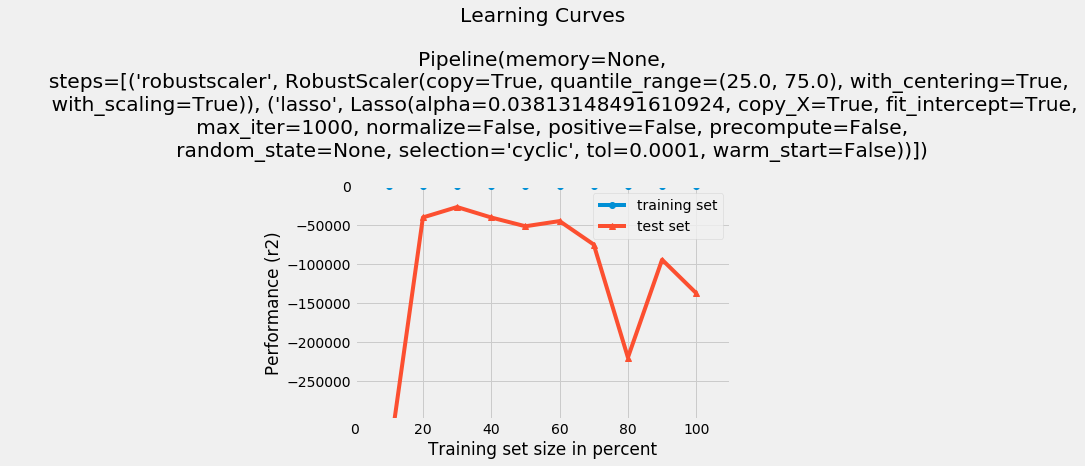

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

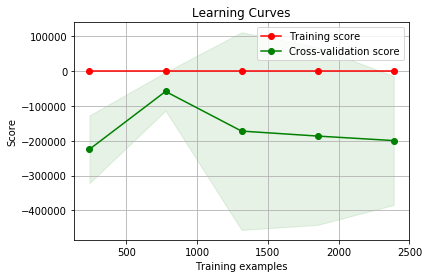

In [49]:

lasso.steps[-1][1].set_params(**best_params)

evalModelByCV(lasso, X_train, y_train, scoring="neg_mean_squared_log_error")
#plot_my_learning_curves(X_train, y_train, X_test, y_test, lasso, scoring="r2", cv=5, n_jobs=n_jobs)

## Elastic net

In [50]:
elasticnet = make_pipeline(
    RobustScaler(),
    ElasticNet()

)
par_space = {
    'alpha':hp.uniform('alpha', 0, 1),
    'l1_ratio':hp.uniform('l1_ratio', 0, 1),
    
}

In [51]:
best_params = {'alpha': 0.03979354323226861, 'l1_ratio': 0.9027788528223015}

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

model score: -212195.536990 (181313.048460)

all scores:  [-119904.22921576  -35664.53200585 -553039.20117325 -121763.8839184
 -230605.83863828]


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

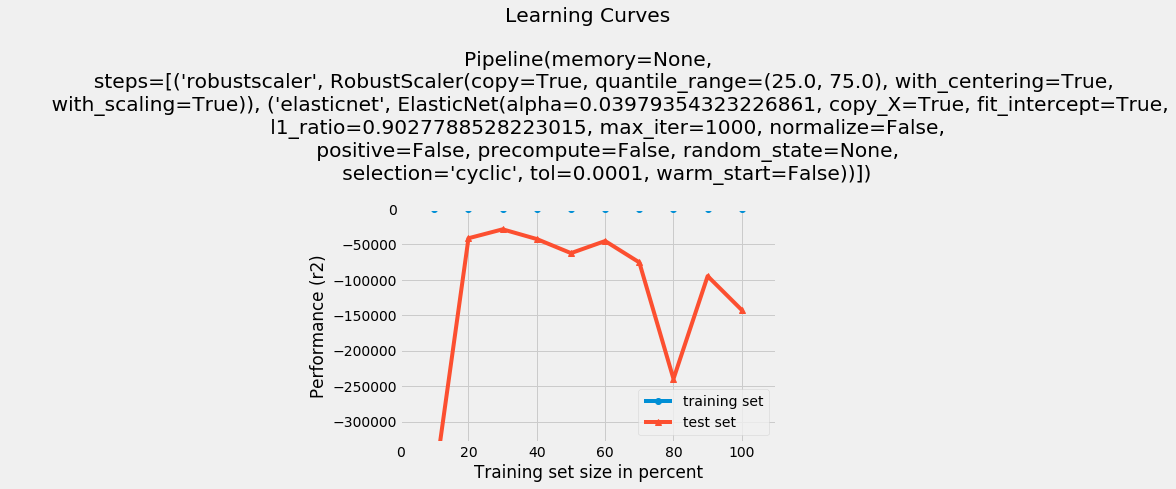

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

KeyboardInterrupt: 

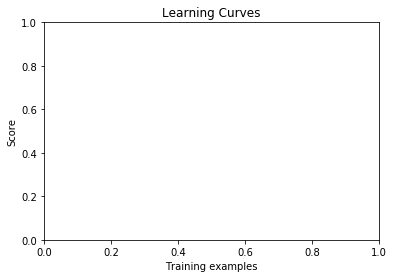

In [52]:

elasticnet.steps[-1][1].set_params(**best_params)

evalModelByCV(elasticnet, X_train, y_train, scoring="neg_mean_squared_log_error")
#plot_my_learning_curves(X_train, y_train, X_test, y_test, elasticnet, scoring="r2", cv=5, n_jobs=n_jobs)


## kernel ridge

In [ ]:
krr = make_pipeline(
        #RobustScaler(),
        KernelRidge()
)

kernel_list = [
    'rbf',
#    'poly',
    'sigmoid']
par_space = {
    'alpha':hp.uniform('alpha', 0, 1),
    'gamma':hp.loguniform('gamma', -8, 2),
    'kernel':hp.choice('kernel', kernel_list),
    'degree':hp.randint('degree', 5),
#    'coef0': # default value is enough
    
}

In [ ]:
best_params = {'alpha': 0.06208805100456642,
 'degree': 2,
 'gamma': 0.000700959885815984,
 'kernel': 'rbf'}

In [ ]:
krr.steps[-1][1].set_params(**best_params)

evalModelByCV(krr, X_train, y_train, scoring="neg_mean_squared_log_error")
#plot_my_learning_curves(X_train, y_train, X_test, y_test, krr, scoring="r2", cv=5, n_jobs=n_jobs)


## k neighbers

In [ ]:
knr = make_pipeline(
    #RobustScaler(),
    KNeighborsRegressor()
)

par_space = {
#    'n_neighbors':hp.choice('n_neighbors', [1,2,3,4,5,6,7,8,9,10]),
#    'n_neighbors':hp.quniform('n_neighbors', 1, 10, 1),
    'n_neighbors':hp.choice('n_neighbors', np.arange(1, 10, dtype=int))
#    'coef0': # default value is enough
    
}

In [ ]:
best_params = {'n_neighbors': 8}

In [ ]:
knr.steps[-1][1].set_params(**best_params)


evalModelByCV(knr, X_train, y_train, scoring="neg_mean_squared_log_error")

#plot_my_learning_curves(X_train, y_train, X_test, y_test, knr, scoring="r2", cv=5, n_jobs=n_jobs)

## Random forest

In [ ]:
ranfore = make_pipeline(
        #RobustScaler(),
        RandomForestRegressor()
)

par_space = {
    'n_estimators':hp.choice('n_estimators', np.arange(1, 100, dtype=int)),
    'max_features':hp.choice('max_features', np.arange(1, 300, dtype=int)),
    'max_depth':hp.choice('max_depth', np.arange(1, 300, dtype=int)),
    'min_samples_split':hp.choice('min_samples_split', np.arange(2, 10, dtype=int)),
    'min_samples_leaf':hp.choice('min_samples_leaf', np.arange(1, 9, dtype=int)),   
}

In [ ]:
best_params = {'max_depth': 5,
 'max_features': 226,
 'min_samples_leaf': 5,
 'min_samples_split': 3,
 'n_estimators': 56}

In [ ]:
ranfore.steps[-1][1].set_params(**best_params)

evalModelByCV(ranfore, X_train, y_train, scoring="neg_mean_squared_log_error")
#plot_my_learning_curves(X_train, y_train, X_test, y_test, ranfore, scoring="r2", cv=5, n_jobs=n_jobs)
# plot feature importance
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(ranfore.named_steps["randomforestregressor"].feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

## gradient boosting

In [ ]:
gboostreg = make_pipeline(
        #RobustScaler(),
        GradientBoostingRegressor()
)

loss_list = ['ls', 'lad', 'huber', 'quantile']

par_space = {
    'n_estimators':hp.choice('n_estimators', np.arange(1, 100, dtype=int)),
    'learning_rate':hp.uniform('learning_rate', 0.000000001, 1.0),
    'max_features':hp.choice('max_features', np.arange(1, 300, dtype=int)),
    'max_depth':hp.choice('max_depth', np.arange(1, 300, dtype=int)),
    'min_samples_split':hp.choice('min_samples_split', np.arange(2, 30, dtype=int)),
    'min_samples_leaf':hp.choice('min_samples_leaf', np.arange(1, 29, dtype=int)),
    'loss':hp.choice('loss', loss_list),
    #'subsample':hp.uniform('learning_rate', 0.0, 1.0),
    
}


In [ ]:
best_params = {'learning_rate': 0.35189025799801155,
 'loss': 'huber',
 'max_depth': 3,
 'max_features': 119,
 'min_samples_leaf': 16,
 'min_samples_split': 19,
 'n_estimators': 48}

In [ ]:
gboostreg.steps[-1][1].set_params(**best_params)

evalModelByCV(gboostreg, X_train, y_train, scoring="neg_mean_squared_log_error")
#plot_my_learning_curves(X_train, y_train, X_test, y_test, gboostreg, scoring="r2", cv=5, n_jobs=n_jobs)
# plot feature importance
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(gboostreg.named_steps["gradientboostingregressor"].feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

## XGBoost

In [ ]:
xgbmodel = make_pipeline(
        #RobustScaler(),
        XGBRegressor()
)


par_space = {
    'n_estimators':hp.choice('n_estimators', np.arange(1, 100, dtype=int)),
    'learning_rate':hp.uniform('learning_rate', 0.000000001, 1.0),
    'max_depth':hp.choice('max_depth', np.arange(1, 300, dtype=int)), 
    'gamma':hp.uniform('gamma', 0.0, 5.0),
    'min_child_weight':hp.uniform('min_child_weight', 0.0, 5.0),
    'subsample': hp.uniform('subsample', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.0, 1.0),
    'reg_alpha': hp.loguniform('reg_alpha', -6, 2),
    'reg_lambda': hp.loguniform('reg_lambda', -6, 2),
    'learning_rate': hp.uniform('learning_rate', 0.000000001, 1.0),
}

In [ ]:
best_params = {'colsample_bytree': 0.4708332878894328,
 'gamma': 4.468853259609137,
 'learning_rate': 0.05617427300476756,
 'max_depth': 227,
 'min_child_weight': 1.8959293704519609,
 'n_estimators': 69,
 'reg_alpha': 0.011073130482133953,
 'reg_lambda': 0.00429738591644784,
 'subsample': 0.034785099220768445}

In [ ]:
xgbmodel.steps[-1][1].set_params(**best_params)

evalModelByCV(xgbmodel, X_train, y_train, scoring="neg_mean_squared_log_error")
#plot_my_learning_curves(X_train, y_train, X_test, y_test, xgbmodel, scoring="r2", cv=5, n_jobs=n_jobs)


xgb.plot_importance(xgbmodel.named_steps["xgbregressor"], max_num_features=15)
plt.show()

# plot feature importance
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(xgbmodel.named_steps["xgbregressor"].feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

## LightGBM

In [55]:
lgbmodel = make_pipeline(
        #RobustScaler(),
        LGBMRegressor()
)

par_space = {
    'learning_rate':hp.uniform('learning_rate', 0.000000001, 1.0),
    'max_depth':hp.choice('max_depth', np.arange(1, 30, dtype=int)), 
    'num_leaves':hp.choice('num_leaves', np.arange(2, 10, dtype=int)),
    'min_data_in_leaf':hp.choice('min_data_in_leaf', np.arange(1, 10, dtype=int)),
    
    'n_estimators':hp.choice('n_estimators', np.arange(1, 100, dtype=int)),
    'max_bin':hp.choice('max_bin', np.arange(2, 30, dtype=int)),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.000000001, 1.0),
    'bagging_freq': hp.randint('bagging_freq', 10),
    'feature_fraction': hp.uniform('feature_fraction', 0.000000001, 1.0),
    'min_sum_hessian_in_leaf': hp.loguniform('min_sum_hessian_in_leaf', -6, 2),
}

"""
par_space = {
    'learning_rate':hp.uniform('learning_rate', 0.000000001, 1.0),
    'max_depth':hp.choice('max_depth', np.arange(1, 300, dtype=int)), 
    'num_leaves':hp.choice('num_leaves', np.arange(2, 100, dtype=int)),
    'min_data_in_leaf':hp.choice('min_data_in_leaf', np.arange(1, 100, dtype=int)),
    
    'n_estimators':hp.choice('n_estimators', np.arange(1, 100, dtype=int)),
    'max_bin':hp.choice('max_bin', np.arange(2, 300, dtype=int)),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.000000001, 1.0),
    'bagging_freq': hp.randint('bagging_freq', 10),
    'feature_fraction': hp.uniform('feature_fraction', 0.000000001, 1.0),
    'min_sum_hessian_in_leaf': hp.loguniform('min_sum_hessian_in_leaf', -6, 2),
}
"""

"\npar_space = {\n    'learning_rate':hp.uniform('learning_rate', 0.000000001, 1.0),\n    'max_depth':hp.choice('max_depth', np.arange(1, 300, dtype=int)), \n    'num_leaves':hp.choice('num_leaves', np.arange(2, 100, dtype=int)),\n    'min_data_in_leaf':hp.choice('min_data_in_leaf', np.arange(1, 100, dtype=int)),\n    \n    'n_estimators':hp.choice('n_estimators', np.arange(1, 100, dtype=int)),\n    'max_bin':hp.choice('max_bin', np.arange(2, 300, dtype=int)),\n    'bagging_fraction': hp.uniform('bagging_fraction', 0.000000001, 1.0),\n    'bagging_freq': hp.randint('bagging_freq', 10),\n    'feature_fraction': hp.uniform('feature_fraction', 0.000000001, 1.0),\n    'min_sum_hessian_in_leaf': hp.loguniform('min_sum_hessian_in_leaf', -6, 2),\n}\n"

In [56]:
%%time
cv_size = 5
max_evals = 5
n_jobs = 1

best_params = searchHyperParam(lgbmodel, par_space, X_train, y_train, scoring="neg_mean_squared_log_error", max_evals=max_evals, cv_size=cv_size, n_jobs=n_jobs)
best_params

Trial  0 , Params  {'bagging_fraction': 0.32152286838411204, 'bagging_freq': 1, 'feature_fraction': 0.9614733737386333, 'learning_rate': 0.21526898577376016, 'max_bin': 9, 'max_depth': 20, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 0.0074313465025117416, 'n_estimators': 80, 'num_leaves': 4}  -> Done. Score :  0.09976224798584692
Trial  1 , Params  {'bagging_fraction': 0.49047348197016394, 'bagging_freq': 8, 'feature_fraction': 0.700491332563535, 'learning_rate': 0.6550952281606509, 'max_bin': 29, 'max_depth': 11, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 1.1885980534775278, 'n_estimators': 95, 'num_leaves': 7}  -> Done. Score :  0.13039944466653877
Trial  2 , Params  {'bagging_fraction': 0.6005842251094713, 'bagging_freq': 1, 'feature_fraction': 0.38117134967624505, 'learning_rate': 0.4887221166688682, 'max_bin': 5, 'max_depth': 29, 'min_data_in_leaf': 1, 'min_sum_hessian_in_leaf': 0.35543705189806135, 'n_estimators': 60, 'num_leaves': 4}  -> Done. Score :  0.10667963504

In [ ]:
# used 100 max_evalus score

best_params = {'bagging_fraction': 0.6488366999217055,
 'bagging_freq': 4,
 'feature_fraction': 0.8769912726752449,
 'learning_rate': 0.2322285924856258,
 'max_bin': 259,
 'max_depth': 46,
 'min_data_in_leaf': 34,
 'min_sum_hessian_in_leaf': 0.011853166137307664,
 'n_estimators': 54,
 'num_leaves': 3}

In [ ]:
lgbmodel.steps[-1][1].set_params(**best_params)


evalModelByCV(lgbmodel, X_train, y_train, scoring="neg_mean_squared_log_error")


#plot_my_learning_curves(X_train, y_train, X_test, y_test, lgbmodel, scoring="r2", cv=5, n_jobs=3)

# plot feature importance
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(lgbmodel.named_steps["lgbmregressor"].feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)


## catboost

## TPOT


# Stacking

In [ ]:
# svr, lasso, elasticnet, krr, knr, ranfore, gboostreg, xgbmodel

stregr = StackingRegressor(regressors=[
    svr,
    lasso, 
    #elasticnet, 
    #krr, 
    #knr, 
    ranfore, 
    gboostreg, 
    xgbmodel,
    lgbmodel,
],
                           meta_regressor=elasticnet)


evalModelByCV(stregr, X_train, y_train, scoring="neg_mean_squared_log_error")


#plot_my_learning_curves(X_train, y_train, X_test, y_test, stregr, scoring="r2", cv=5, n_jobs=n_jobs)



In [ ]:
# https://rasbt.github.io/mlxtend/api_subpackages/mlxtend.regressor/
stregr.coef_

In [ ]:
# Training the stacking classifier with all train data

stregr.fit(train_df, y_train_df)

# Make submission file


In [ ]:
sub = pd.DataFrame()
sub['ID'] = id_test_df
sub['target'] = np.expm1(stregr.predict(test_df))
sub.to_csv('../output/submission.csv', index=False)
